「RとStanで始めるベイズ統計モデリングによるデータ分析入門」「実践編第5部第3章 状態空間モデルによる予測と補完」を対象に，公開されているR，Stanのコードをpython，pystanのコードへと書き直した一例です。Stanの代わりにpystanを利用しています。

本ページでは公開されていない書籍の内容については一切触れません。理論や詳しい説明は書籍を参照してください。

なお，こちらで紹介しているコードには誤りが含まれる可能性があります。内容やコードについてお気づきの点等ございましたら，ご指摘いただけると幸いです。

# 分析の準備
## パッケージの読み込み

In [15]:
import pystan
import datetime
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Meiryo'

## データの読み込み

In [3]:
sales_df_all = pd.read_csv('5-2-1-sales-ts-1.csv')
sales_df_all['date'] = pd.to_datetime(sales_df_all['date'])
sales_df_all.head(n=3)

,date,sales
0,2010-01-01,23.9
1,2010-01-02,19.0
2,2010-01-03,20.3


# ローカルレベルモデルによる予測の実行


## データの準備

In [4]:
data_list_pred = dict(T=len(sales_df_all),
                      y=sales_df_all['sales'],
                      pred_term=20)

## モデルの推定

In [5]:
# stanコードの記述(5-3-1-local-level-pred.stan)
stan_code = '''
data {
  int T;         // データ取得期間の長さ
  vector[T] y;   // 観測値
  int pred_term; // 予測期間の長さ
}

parameters {
  vector[T] mu;       // 状態の推定値(水準成分)
  real<lower=0> s_w;  // 過程誤差の標準偏差
  real<lower=0> s_v;  // 観測誤差の標準偏差
}

model {
  // 状態方程式に従い、状態が遷移する
  for(i in 2:T) {
    mu[i] ~ normal(mu[i-1], s_w);
  }
  
  // 観測方程式に従い、観測値が得られる
  for(i in 1:T) {
    y[i] ~ normal(mu[i], s_v);
  }
}

generated quantities{
  vector[T + pred_term] mu_pred; // 予測値も含めた状態の推定値
  
  // データ取得期間においては、状態推定値muと同じ
  mu_pred[1:T] = mu;
  
  // データ取得期間を超えた部分を予測
  for(i in 1:pred_term){
    mu_pred[T + i] = normal_rng(mu_pred[T + i - 1], s_w);
  }
}

'''

# モデルのコンパイル
stan_model_llp = pystan.StanModel(model_code=stan_code)

# サンプリング
local_level_pred = stan_model_llp.sampling(data=data_list_pred,
                                           seed=1,
                                           n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_034be78dc0fa71b8d5e9e6b8edac86e4 NOW.


## 参考：結果の確認

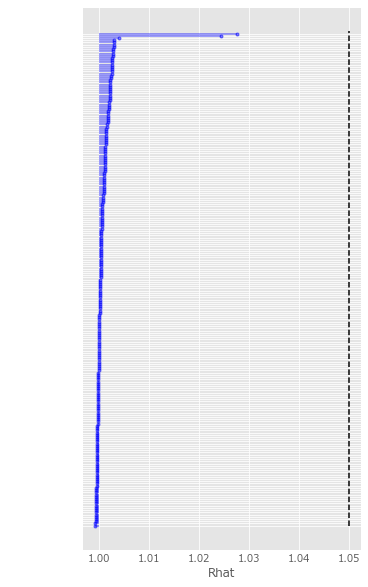

In [10]:
# 収束確認用のRhatのプロット関数
def mcmc_rhat(dataframe, column='Rhat', figsize=(5, 10)):
    plt.figure(figsize=figsize)
    plt.hlines(y=dataframe[column].sort_values().index,
               xmin=1,
               xmax=dataframe[column].sort_values(),
               color='b',
               alpha=0.5)
    plt.vlines(x=1.05, ymin=0, ymax=len(dataframe[column]), linestyles='--')
    plt.plot(dataframe[column].sort_values().values,
             dataframe[column].sort_values().index,
             marker='.',
             linestyle='None',
             color='b',
             alpha=0.5)
    plt.yticks(color='None')
    plt.tick_params(length=0)
    plt.xlabel(column)
    plt.show()


# 各推定結果のデータフレームを作成
summary = pd.DataFrame(local_level_pred.summary()['summary'],
                       columns=local_level_pred.summary()['summary_colnames'],
                       index=local_level_pred.summary()['summary_rownames'])

# プロット
mcmc_rhat(summary)

## 参考：結果の確認

In [12]:
print(local_level_pred.stansummary(pars=["s_w", "s_v", "lp__"],
                                   probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_034be78dc0fa71b8d5e9e6b8edac86e4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
s_w     1.3    0.02   0.32   0.79   1.26   2.05    230   1.02
s_v    2.87  6.3e-3   0.26   2.39   2.86   3.42   1740    1.0
lp__ -225.5    1.35  19.48 -264.7 -225.3 -188.2    207   1.03

Samples were drawn using NUTS at Sat Sep  5 00:02:02 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## 図示

### 予測対象期間も含めた日付を用意

In [22]:
date_plot = pd.date_range('2010-1-1', periods=120, freq='D')

### 参考

DatetimeIndex(['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04',
               '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
               '2010-01-09', '2010-01-10',
               ...
               '2010-04-21', '2010-04-22', '2010-04-23', '2010-04-24',
               '2010-04-25', '2010-04-26', '2010-04-27', '2010-04-28',
               '2010-04-29', '2010-04-30'],
              dtype='datetime64[ns]', length=120, freq='D')

In [23]:
help(pd.date_range)

Help on function date_range in module pandas.core.indexes.datetimes:

date_range(start=None, end=None, periods=None, freq=None, tz=None, normalize=False, name=None, closed=None, **kwargs) -> pandas.core.indexes.datetimes.DatetimeIndex
    Return a fixed frequency DatetimeIndex.
    
    Parameters
    ----------
    start : str or datetime-like, optional
        Left bound for generating dates.
    end : str or datetime-like, optional
        Right bound for generating dates.
    periods : int, optional
        Number of periods to generate.
    freq : str or DateOffset, default 'D'
        Frequency strings can have multiples, e.g. '5H'. See
        :ref:`here <timeseries.offset_aliases>` for a list of
        frequency aliases.
    tz : str or tzinfo, optional
        Time zone name for returning localized DatetimeIndex, for example
        'Asia/Hong_Kong'. By default, the resulting DatetimeIndex is
        timezone-naive.
    normalize : bool, default False
        Normalize start/

In [24]:
mcmc_sample = local_level_pred.extract()

In [30]:
mcmc_sample['mu_pred'].shape

(4000, 120)